### Aplicando análisis de componentes principales

Una vez hemos limpiado el dataset de imagenes, deseamos conocer hasta qué punto podríamos reducir la dimensionalidad de las mismas preservando en ellas las secciones más importantes, es decir, que se puedan seguir identificando la distribución de la dentadura, problemas de caries, entre otras afecciones dentales

Dependiendo de los resultados de este análisis podríamos:
- Contar un cojunto de imagenes de menor peso y tamaño lo que nos permitirá probar modelos de clusterización complejos.
- Reducir el "ruido" en las imagenes.  El ruido bajo el escenario de nuestro proyecto está representado por aquellos pixeles que se encuentran alrededor de los labios, las mejillas y alrededor de la mandibula, por lo que esperamos una gran reducción de dimensionalidad aplicando esta técnica.
- Poder visualizarlas de manera eficiente en caso de requerirse.

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from pca import pca
from scipy.linalg import svd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# !pip install tables

Cargamos en un dataframe las imagenes y sus propiedades tras el proceso de limpieza y transformación realizado previamente en 2_Clean_dataset.ipynb.

In [30]:
df = pd.read_hdf('2_Cleaned_dataset/images.h5', key='data')
df.shape

(910, 11)

In [31]:
df.head()

,full_path,main_folder,intermediate_path,file_name,category,format,height,width,size,bands,image
0,2_Cleaned_dataset\images\Adult_1.png,images,images,Adult_1.png,Adult,PNG,188,398,38377,1,"[[207, 196, 188, 185, 192, 199, 216, 233, 239,..."
1,2_Cleaned_dataset\images\Adult_10.png,images,images,Adult_10.png,Adult,PNG,188,398,36997,1,"[[197, 209, 205, 191, 174, 158, 146, 150, 158,..."
2,2_Cleaned_dataset\images\Adult_100.png,images,images,Adult_100.png,Adult,PNG,188,398,37350,1,"[[164, 158, 141, 148, 157, 154, 172, 183, 186,..."
3,2_Cleaned_dataset\images\Adult_101.png,images,images,Adult_101.png,Adult,PNG,188,398,36627,1,"[[150, 138, 138, 136, 125, 128, 128, 131, 121,..."
4,2_Cleaned_dataset\images\Adult_102.png,images,images,Adult_102.png,Adult,PNG,188,398,37176,1,"[[202, 201, 193, 190, 192, 190, 183, 179, 181,..."


Obtenemos una muestra del dataframe y visualizamos algunas de las imágenes disponibles

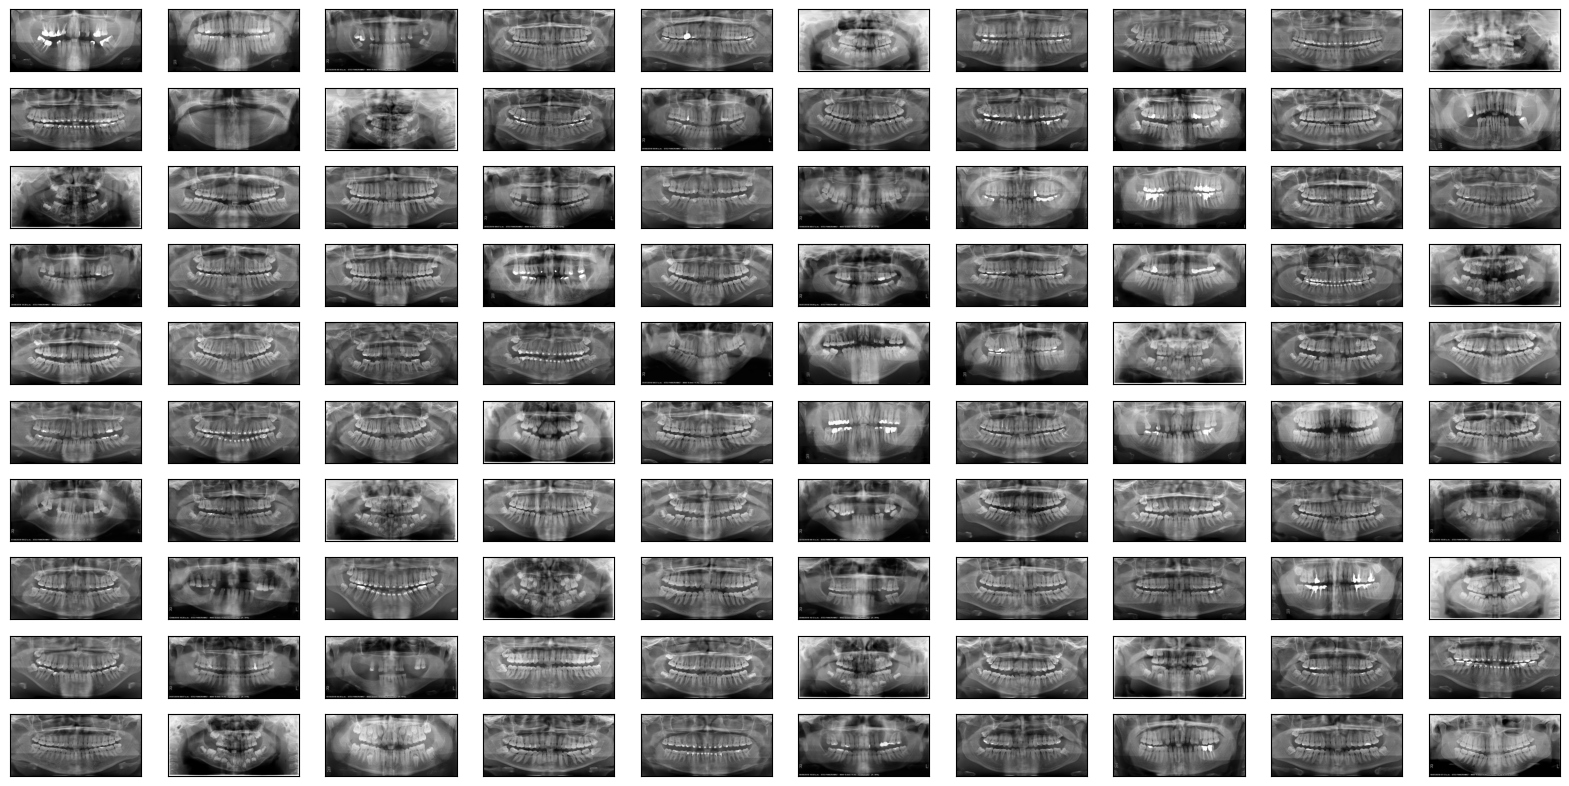

In [32]:
# Obtenemos una muestra del dataframe para trabajar un poco más rápido
df_sample = df.sample(n=100)

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow((df_sample[i:i+1]['image'].values[0]), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [33]:
# Aplanamos las imágenes antes de crear una matriz de valores estandarizados
X = np.stack(df['image'].apply(lambda x: x.flatten()))
X.shape

(910, 74824)

In [34]:
# Estandarizamos los datos
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Crea un DataFrame a partir de los datos escalados
X_standardized_df = pd.DataFrame(X_standardized)
X_standardized_df

,0,1,2,3,4,5,6,7,8,9,...,74814,74815,74816,74817,74818,74819,74820,74821,74822,74823
0,0.343527,0.118632,-0.030663,-0.081757,0.080161,0.249434,0.631962,0.988661,1.118684,1.325216,...,-0.841336,-0.844258,-0.847812,-0.854670,-0.862017,-0.873673,-0.891742,-0.918227,-0.953645,-1.017619
1,0.132661,0.390085,0.323863,0.042899,-0.293390,-0.608614,-0.836055,-0.731730,-0.552981,-0.684419,...,-0.680057,-0.672505,-0.687132,-0.683567,-0.680068,-0.680488,-0.697646,-0.722692,-0.745391,-0.807518
2,-0.563199,-0.674846,-1.010824,-0.850467,-0.646189,-0.692326,-0.290792,-0.047719,0.024879,-0.021446,...,-0.830584,-0.833524,-0.815676,-0.801200,-0.797800,-0.787813,-0.816260,-0.907364,-0.898841,-0.752229
3,-0.858413,-1.092466,-1.073388,-1.099779,-1.310280,-1.236454,-1.213545,-1.125554,-1.316580,-1.347391,...,-0.841336,-0.844258,-0.847812,-0.854670,-0.862017,-0.873673,-0.891742,-0.918227,-0.953645,-1.017619
4,0.238094,0.223037,0.073609,0.022123,0.080161,0.061082,-0.060103,-0.130629,-0.078310,-0.062882,...,-0.680057,-0.683239,-0.708556,-0.715649,-0.712177,-0.712685,-0.719212,-0.733555,-0.767312,-0.829634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,1.355687,1.329729,1.324879,1.310232,1.283825,1.274906,1.282083,1.278848,1.283787,1.263063,...,1.868162,1.860860,1.862318,1.861594,1.856514,1.863115,1.857959,1.851854,1.841345,1.802146
906,1.355687,1.350610,1.345734,1.331008,1.325331,1.337690,1.344998,1.341030,1.366338,1.366652,...,1.803650,1.817921,1.830182,1.829512,1.845811,1.841650,1.847176,1.851854,1.841345,1.802146
907,1.355687,1.308848,1.220607,1.164800,1.097050,1.044698,0.988480,0.947206,0.953581,0.973012,...,1.868162,1.860860,1.862318,1.861594,1.856514,1.852382,1.847176,1.851854,1.841345,1.802146
908,1.355687,1.350610,1.345734,1.310232,1.304578,1.316762,1.303055,1.299575,1.304424,1.325216,...,1.857410,1.860860,1.851606,1.861594,1.856514,1.852382,1.857959,1.851854,1.841345,1.802146


Ahora identificaremos qué tanto podríamos reducir la dimension de las imágenes de manera que aún pueda explicarse entre el 90% y 95% de la varianza.   Nos apoyaremos en el módulo pca de la librería con el mismo nombre.  Como nuestras imagenes están representadas por 74824 columnas o posiciones,  dejamos que el algoritmo de pca encuentre el número de componentes principales por nosotros.  Al no especificar el número de componentes que deseamos el algoritmo por defecto resaltará aquella cantidad de componentes principales que explican el 95% de la varianza.

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [74824] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [348] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [74824] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[348]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


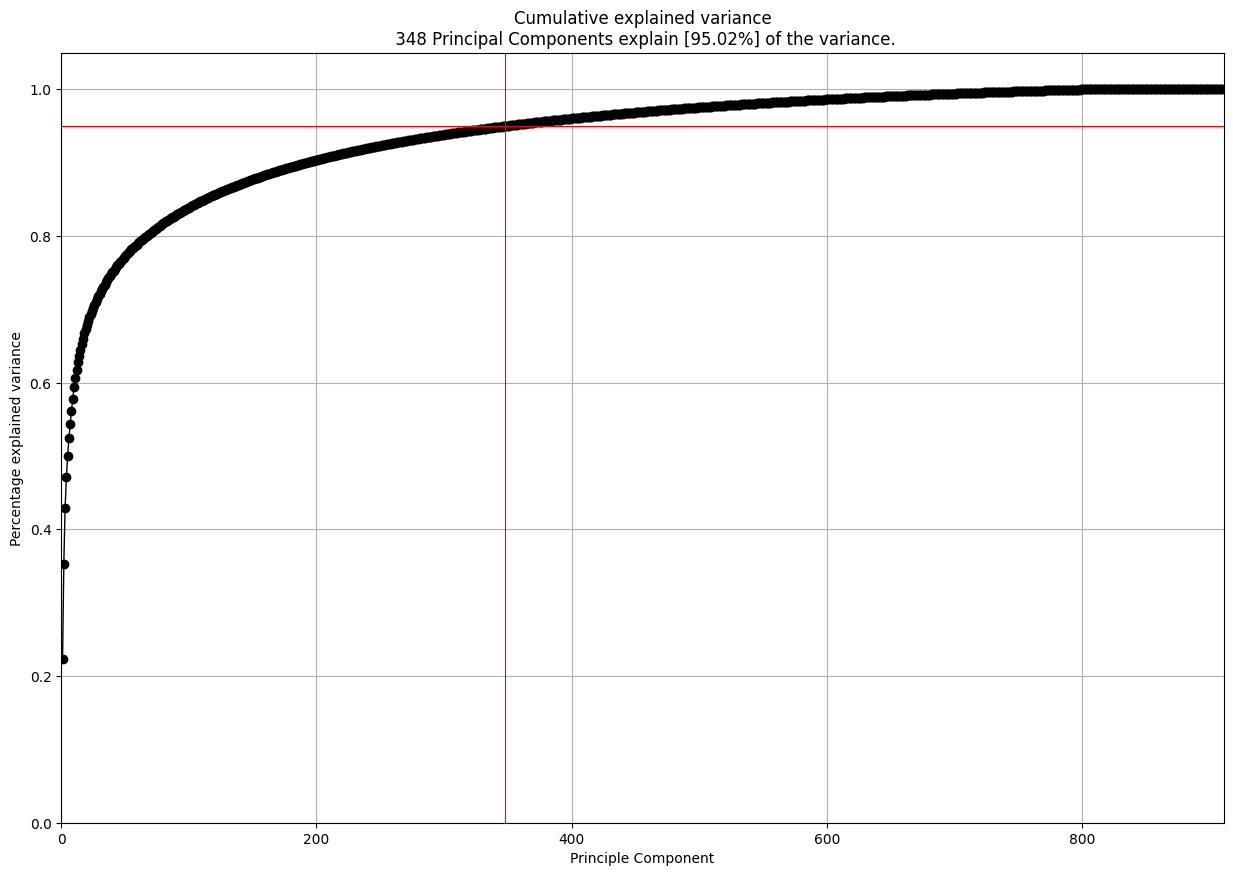

In [35]:
model = pca()
model.fit_transform(X_standardized_df)
fig, ax = model.plot()

Encontramos entonces que 348 componentes explican el 95.02% de la varianza de las imagenes.

In [36]:
pca_model = PCA(n_components=348)
X_reduced = pca_model.fit_transform(X)
X_reduced

array([[-3.39874518e+03, -3.36958477e+03,  7.25743665e+03, ...,
         1.12510215e+01, -6.60236015e+01, -3.04673692e+01],
       [-3.66666698e+03, -4.29900278e+03,  5.49097153e+03, ...,
         2.32545441e+02, -2.01797266e+02, -2.10013650e+01],
       [-4.29658289e+03, -2.24047416e+03,  7.12835585e+03, ...,
        -1.49933397e+02,  9.19439473e+01, -9.34358441e+01],
       ...,
       [ 1.20021733e+04, -1.89311608e+03, -2.92099721e+03, ...,
         8.71549586e+01, -3.21436080e+01,  3.07499303e+01],
       [ 1.26531974e+04,  2.74662948e+03,  7.30060891e+02, ...,
        -4.83446583e+01, -2.97242237e+01,  3.93233027e+01],
       [ 1.33352288e+04, -3.50518182e+03,  3.62859279e+03, ...,
        -1.72743927e+02, -1.30348482e+02,  1.48242664e+02]])

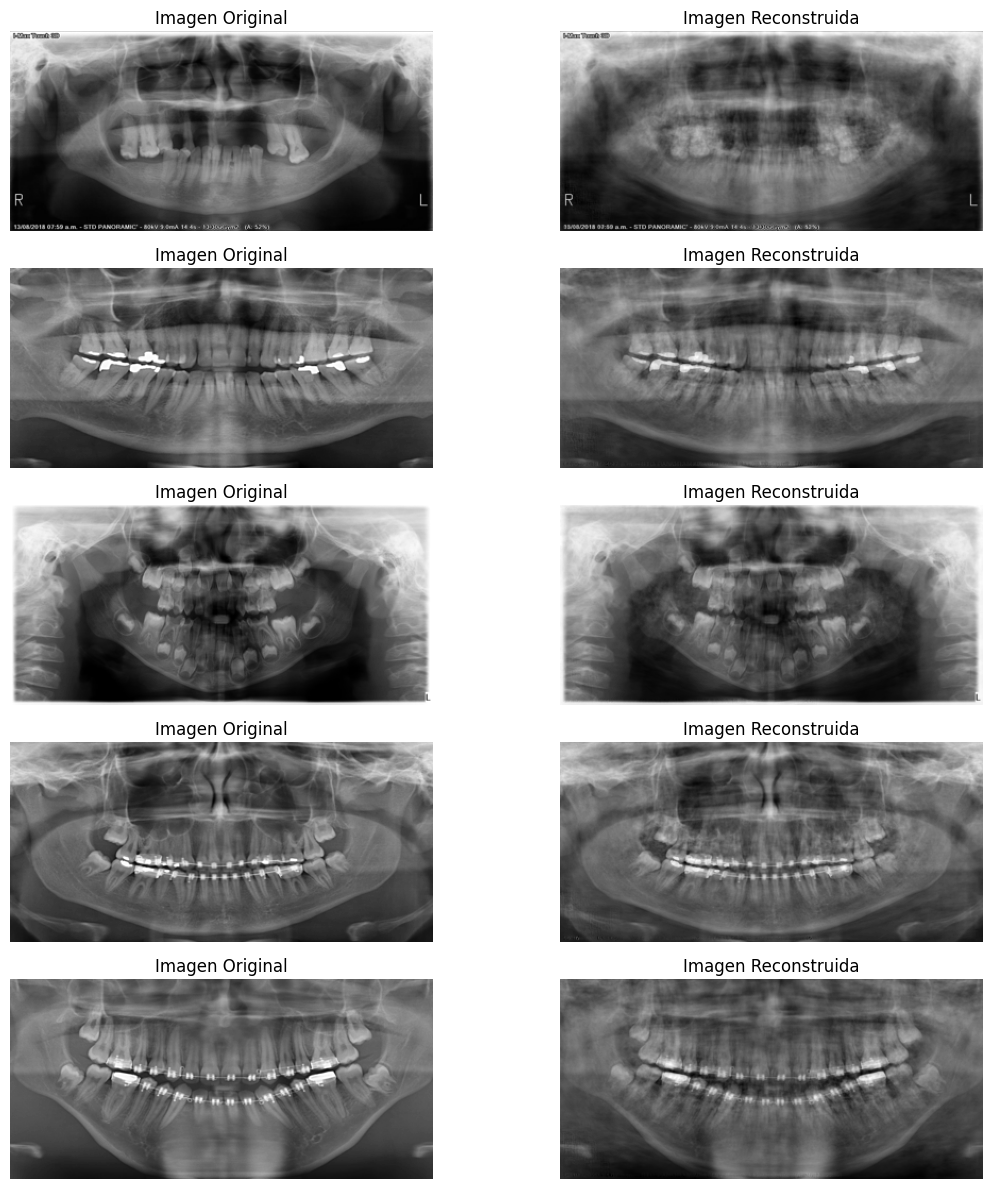

In [37]:
def plot_samples(df, reduced):
    # Número de pares de imágenes a mostrar
    num_pairs = 5
    random_indices = np.random.randint(0, len(X), size=num_pairs)

    # Crear una figura con subtramas para los pares de imágenes
    plt.figure(figsize=(12, 12))

    for i, random_index in enumerate(random_indices):
        # Obtener una imagen al azar y su correspondiente reducida
        sample = df.iloc[random_index]['image']
        sample_reduced = reduced[random_index]

        sample_original = pca.inverse_transform([sample_reduced])
        sample_original = sample_original[0]

        # Subtrama para la imagen original
        plt.subplot(num_pairs, 2, 2 * i + 1)
        plt.imshow(sample.reshape((188, 398)), cmap='gray')
        plt.title('Imagen Original')
        plt.axis('off')

        # Subtrama para la imagen reconstruida
        plt.subplot(num_pairs, 2, 2 * i + 2)
        plt.imshow(sample_original.reshape((188, 398)), cmap='gray')
        plt.title('Imagen Reconstruida')
        plt.axis('off')

    # Ajustar el espaciado entre las subtramas
    plt.tight_layout()
    plt.show()

plot_samples(df, X_reduced)

Vemos que se pierde muchos detalles, volvamos a evaluar la varianza explicada, sabemos que por encima de 300 componentes se explica el 90% de la varianza. podemos revisar valores superiores a los 350 componentes.  Segun la grafica de la variazan explicada anterior un valor óptimo puede ser 700.

In [10]:
def get_explained_variance_ratio(n):
    model = PCA(n)
    model.fit_transform(X_standardized_df)
    explained_variance_ratio = model.explained_variance_ratio_
    total_explained_variance = sum(explained_variance_ratio)
    print(f"Porcentaje de varianza explicada para {n} componentes: {total_explained_variance}")

[get_explained_variance_ratio(i) for i in [350, 400, 500, 600, 700]]

Porcentaje de varianza explicada para 350 componentes: 0.9496946007144798
Porcentaje de varianza explicada para 400 componentes: 0.9596066135805089
Porcentaje de varianza explicada para 500 componentes: 0.9748847522859971
Porcentaje de varianza explicada para 600 componentes: 0.9859207627099551
Porcentaje de varianza explicada para 700 componentes: 0.9940360751669112


[None, None, None, None, None]

700 componentes explican el 99.4% de la varianza, por lo que podemos hacer un nuevo intento

In [38]:
pca_model_700 = PCA(n_components=700)
X_reduced_700 = pca_model_700.fit_transform(X)
X_reduced_700

array([[-3.39874518e+03, -3.36958477e+03,  7.25743665e+03, ...,
         8.73055719e+01,  5.34577549e+01, -8.58198092e+01],
       [-3.66666698e+03, -4.29900278e+03,  5.49097153e+03, ...,
         8.74248362e+01,  8.17299665e+01, -5.33856035e+00],
       [-4.29658289e+03, -2.24047416e+03,  7.12835585e+03, ...,
         3.70393666e+00, -3.74314058e+01, -2.41775336e+01],
       ...,
       [ 1.20021733e+04, -1.89311608e+03, -2.92099721e+03, ...,
         5.59816058e+00, -3.31203865e+01, -5.57061112e+00],
       [ 1.26531974e+04,  2.74662948e+03,  7.30060891e+02, ...,
         4.06558977e+01,  2.39601451e+01, -9.11602926e+00],
       [ 1.33352288e+04, -3.50518182e+03,  3.62859279e+03, ...,
         1.93829750e+01, -2.82285967e+01,  7.70845935e+00]])

In [39]:
plot_samples(df, X_reduced_700)

ValueError: shapes (1,700) and (348,74824) not aligned: 700 (dim 1) != 348 (dim 0)

<Figure size 1200x1200 with 0 Axes>

### Evaluemos SVD como técnica para reducción de la dimensionalidad

SVD es otra técnica ampliamente conocida para reducir la dimensionalidad de los datos. A diferencia de PCA, SVD permite un mayor control sobre la cantidad de información que se desea retener y es más robusta a los valores faltantes.  Aunque en nuestro contexto no se presentan datos faltantes podríamos realizar una comparación sencilla, para determinar por ejemplo, cuál de las dos técnicas nos permite reducir la imagen de tal manera que se ocupe el menor espacio en disco o memoria.

Tomamos una imagen de nuestro conjunto de imágenes ya reducidas con PCA y calculamos su tamaño en memoria:

In [13]:
import sys
size = sys.getsizeof(X_reduced[0])
print(f"La imagen ocupa {size} bytes")

La imagen ocupa 112 bytes


Ahora aplicaremos SVD a la misma imagen

Dimensión: 188x398


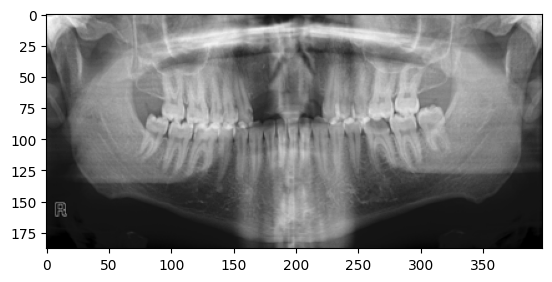

In [14]:
# Obtenemos la imagen
sample = df[:1]['image'][0]
n, k = sample.shape
print(f"Dimensión: {n}x{k}" )

# La visualizamos
plt.imshow(sample, cmap='gray')
plt.show()

In [15]:
# Aplicamos SVD
def svd_truncada(image, l):
    """
     Esta función retorna la aproximación a la matriz original a partir de la SVD truncada

    Parameters:
        l (int):  número de valores singulares a utilizar en la reconstrucción
        X (array): matriz original a descomponer

    Returns:
        resultado (array): reconstrucción de X con l componentes principales
    """
    # SVD 
    U,S,Vt = svd(image)
    S2= np.resize(S,[l,1])*np.eye(l,l) #ponemos los valores singulares en una matriz diagonal
    
    # SVD truncada
    return(np.dot(U[:,0:l],np.dot(S2,Vt[0:l,:])))
    
U, S, Vt = svd(sample)

Realizamos varios intentos de visualización y encontramos que la cantidad de valores singulares que nos permite obtener una imagen con una imagen similar a la reducida con PCA es 40.

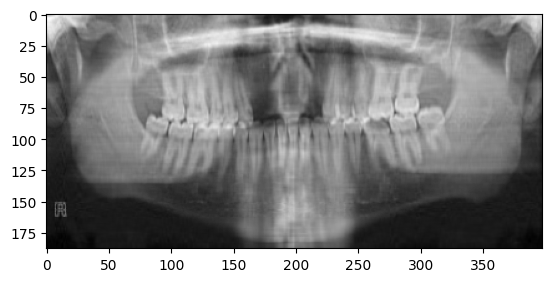

In [16]:
plt.imshow(svd_truncada(sample, 40), cmap='gray')
plt.show()

Revisamos cuánta varianza logran explicar esos 45 valores singulares

In [17]:
var_explained = np.round(S**2/np.sum(S**2), decimals=6)
sum(var_explained[0:40])

0.999268995175953

Los 40 valores singulares explican el 99.92% de la varianza en contraste con el 99.94% de varianza explicada con los 700 componentes principales usando PCA.  Veamos ahora cuánto ocupa en memoria esta imagen reducida con SVD:

In [18]:
size_SVD = sys.getsizeof(svd_truncada(sample, 40))
print(f"La imagen ocupa {size_SVD} bytes")

La imagen ocupa 598720 bytes


Vemos que, aunque aparentemente la calidad de las 2 imagenes reducidas obtenidas luego de realizar la reducción con PCA y SVD es similar, en memoria las imágenes terminan ocupando un menor espacio. por lo que optamos por mantener la reducción que realizamos con PCA pues representará beneficios computacionales en posteriores etapas del proyecto.

In [23]:
# Finalmente exportamos la matriz de imagenes reducidas para usarlas en análisis posteriores y no tener que ejecutar este notebook completo nuevamente.
file_name = 'X_reduced.csv'
target_path = '3_Reduced_dataset'

# Comprueba si la carpeta existe y, si no, la crea
if not os.path.exists(target_path):
    os.makedirs(target_path)

df_reduced = pd.DataFrame(X_reduced)

# Ruta completa del archivo CSV incluyendo la carpeta de destino
full_path = os.path.join(target_path, file_name)
df_reduced.to_csv(full_path, index=False)
